In [7]:
%load_ext tensorboard
import IPython.display as display
from tensorflow import keras as keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import CSVLogger
import pathlib
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [8]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(className[label_batch[n]==1][0].title())
      plt.axis('off')

['A' 'K' 'N' 'E' 'L' 'I' 'O' 'T' 'W' 'C' 'V' 'H' 'Q' 'D' 'P' 'U' 'M' 'S'
 'R' 'B' 'Y' 'X' 'G' 'F']
Found 1525 images belonging to 24 classes.
Found 168 images belonging to 24 classes.


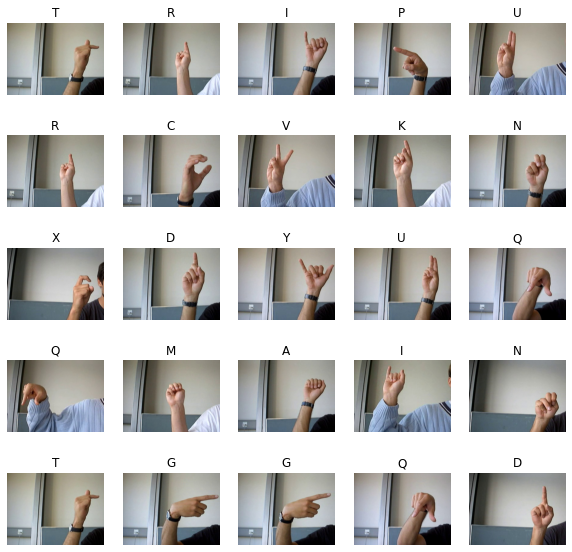

In [9]:
data_path = pathlib.Path('dataset/')
image_count = len(list(data_path.glob('*/*.jpg')))
classes = [c.name[0] for c in data_path.glob('*') if c.name[0] != '.']
className = np.array([classes][0])
print(className)
imgHeight = 240
imgWeight = 320
batchSize = 32
data_gen = ImageDataGenerator(rescale=1./255,validation_split=0.1)
train_gen = data_gen.flow_from_directory(directory=str(data_path),
                                        target_size=(imgHeight,imgWeight),
                                        batch_size = batchSize,
                                        classes = list(classes),
                                        shuffle = True,
                                        subset = 'training')
vali_gen = data_gen.flow_from_directory(directory=str(data_path),
                                        target_size=(imgHeight,imgWeight),
                                        batch_size = batchSize,
                                        classes = list(classes),
                                        shuffle = True,
                                        subset = 'validation')

x,y = next(vali_gen)
show_batch(x,y)

In [10]:
baseModel = InceptionV3(input_shape=(imgHeight,imgWeight,3),weights='imagenet', include_top=False)
log_dir ='./tf-log/'
filepath='./weights.epoNum:{epoch:02d}-val_loss:{val_loss:.3f}-val_accuracy:{val_accuracy:.3f}.hdf5'
 #----TensorBoard----
#寫出一個以events.out開頭的log file(內含訓練過程的數據)供tensorboard(可視化工具)日後開啟
tb=TensorBoard(log_dir=log_dir, histogram_freq=0)
#----EarlyStopping----
#val_loss只要連續patience次都沒有進步(一次變動大於min_delta即有進步)就停止訓練
early_stopping = EarlyStopping(monitor='val_loss',patience=30,min_delta=0.001)
#----ModelCheckpoint----
#save_best_only=True表示訓練過程中有進步的模型便儲存起來
ckp = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#將訓練過程的數據都存成csv檔
csv_logger = CSVLogger('log.csv', append=True, separator=';')
#將上述函式組起來
callbacks_list = [tb, early_stopping,ckp,csv_logger]

In [5]:
x= baseModel.output
x= GlobalAveragePooling2D()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='tanh')(x)
predictions = Dense(len(className), activation='softmax')(x)
model = Model(baseModel.input, predictions)
for layer in model.layers:
    layer.trainable = True

model.compile(keras.optimizers.Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
history_ft = model.fit(
        train_gen,
        steps_per_epoch=train_gen.samples//batchSize,  
        epochs=100,
        validation_data=vali_gen,
        validation_steps=vali_gen.samples//batchSize,  
        verbose=1,
        callbacks=callbacks_list
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 47 steps, validate for 5 steps
Epoch 1/100
46/47 [============================>.] - ETA: 0s - loss: 1.9406 - accuracy: 0.5209
Epoch 00001: val_loss improved from inf to 1.43333, saving model to ./weights.epoNum:01-val_loss:1.433-val_accuracy:0.519.hdf5
47/47 [==============================] - 35s 748ms/step - loss: 1.9097 - accuracy: 0.5305 - val_loss: 1.4333 - val_accuracy: 0.5188
Epoch 2/100
46/47 [============================>.] - ETA: 0s - loss: 0.1583 - accuracy: 0.9699
Epoch 00002: val_loss improved from 1.43333 to 0.29562, saving model to ./weights.epoNum:02-val_loss:0.296-val_accuracy:0.913.hdf5
47/47 [==============================] - 23s 481ms/step - loss: 0.1555 - accuracy: 0.9705 - val_loss: 0.2956 - val_accuracy: 0.9125
Epoch 3/100
46/47 [============================>.] - ETA: 0s - loss: 0.0229 - accuracy: 1.0000
Epoch 00003: val_loss improved from 0.29562 to 0.02963, saving model to ./weights.epoNum:03-val_loss:0

In [8]:
%tensorboard --logdir tf-log/ --host=0.0.0.0 --port=6008